### <b>4.4 MODELATGE PREDICTIU</b>

#### <b>4.4.2 Model base: GLM/GAM</b>

In [3]:
# =====================================================================
# 4.4.2 MODEL BASE: GLM PER A FREQÜÈNCIA I SEVERITAT (versió arreglada)
# =====================================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import (
    roc_auc_score,
    brier_score_loss,
    log_loss,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from math import sqrt
from statsmodels.genmod.families.links import Log


# ---------------------------------------------------------------------
# 1. Càrrega de dades
# ---------------------------------------------------------------------

# Directori base on s'han desat els datasets finals després de l'enginyeria
base_model_path = "data/model"

FREQ_TRAIN_PATH = f"{base_model_path}/freq_glm_train.csv"
FREQ_TEST_PATH  = f"{base_model_path}/freq_glm_test.csv"

SEV_TRAIN_PATH  = f"{base_model_path}/sev_train.csv"
SEV_TEST_PATH   = f"{base_model_path}/sev_test.csv"

freq_train = pd.read_csv(FREQ_TRAIN_PATH)
freq_test  = pd.read_csv(FREQ_TEST_PATH)
sev_train  = pd.read_csv(SEV_TRAIN_PATH)
sev_test   = pd.read_csv(SEV_TEST_PATH)

print("Freq GLM train/test:", freq_train.shape, freq_test.shape)
print("Severitat train/test:", sev_train.shape, sev_test.shape)

# ---------------------------------------------------------------------
# 2. Exclusions conceptuals
# ---------------------------------------------------------------------
target_freq = "Has_claims_year"
target_sev  = "Cost_claims_year"

exclude_freq = ["ID", "Policy_year", "set_type"]
exclude_sev  = ["ID", "Policy_year", "set_type", "Has_claims_year", target_sev]

# =====================================================================
# 3. Predictors manuals definits per mi
# =====================================================================

freq_predictors_manual = [
    "Licence_age",
    "Vehicle_age",
    "Policy_duration",
    "Power",
    "Seniority",
    "Type_risk_ord",
    "Area_1",
    "Type_fuel_D",
    "Type_fuel_Unknown",
    "Distribution_channel_1",
    "Second_driver_1",
    "Has_lapse_1",
    "Has_claims_history_1",
    "Value_to_power",
    "Premium_to_value",
]

sev_predictors_manual = [
    "Licence_age",
    "Vehicle_age",
    "Policy_duration",
    "Power",
    "Power_log",
    "Value_vehicle",
    "Value_vehicle_log",
    "Weight",
    "Type_risk_ord",
    "Area",
    "Premium",
    "Premium_to_value",
    "Power_x_Value_vehicle",
]

print("\n[FREQ] Predictors manuals:", freq_predictors_manual)
print("\n[SEV] Predictors manuals refined:", sev_predictors_manual)

# ---------------------------------------------------------------------
# 4. Funcions de selecció automàtica (només dins l'espai manual)
# ---------------------------------------------------------------------
def select_auto_predictors_from_manual(
    df: pd.DataFrame,
    target_col: str,
    manual_cols,
    max_vars: int,
    corr_threshold: float = 0.80,
):
    """
    Selecció greedy dins l'espai manual, prioritzant |ρ| amb el target,
    evitant correlacions mútues excessives entre predictors.
    """
    # només candidates manuals que existeixen i són numèriques
    manual_numeric = [
        c for c in manual_cols
        if c in df.columns and pd.api.types.is_numeric_dtype(df[c]) and df[c].nunique() > 1
    ]

    if not manual_numeric:
        raise ValueError("No hi ha columnes manuals numèriques vàlides per a fer selecció auto.")

    # correlació amb el target
    corrs = [(c, abs(df[c].corr(df[target_col]))) for c in manual_numeric]
    corrs = [c for c in corrs if not pd.isna(c[1])]
    corrs.sort(key=lambda x: x[1], reverse=True)

    selected = []
    for col, _ in corrs:
        if len(selected) >= max_vars:
            break
        # comprovem correlació mútua amb les ja seleccionades
        ok = True
        for s in selected:
            cs_corr = df[[col, s]].corr().iloc[0,1]
            if abs(cs_corr) >= corr_threshold:
                ok = False
                break
        if ok:
            selected.append(col)
    return selected

# =====================================================================
# 5. FREQ – Selecció auto (dins 15 manuals), màx 12 predictors
# =====================================================================
freq_predictors_auto = select_auto_predictors_from_manual(
    df=freq_train,
    target_col=target_freq,
    manual_cols=freq_predictors_manual,
    max_vars=12,
    corr_threshold=0.80,
)

freq_predictors_final = freq_predictors_auto

print("\n[FREQ] Predictors finals freq:", freq_predictors_final)
print("[FREQ] Nº predictors finals:", len(freq_predictors_final))

# GLM Binomial
X_train_freq = sm.add_constant(freq_train[freq_predictors_final].fillna(0.0))
X_test_freq  = sm.add_constant(freq_test[freq_predictors_final].fillna(0.0))
y_train_freq = freq_train[target_freq].astype(int)
y_true_freq  = freq_test[target_freq].astype(int)

freq_glm = sm.GLM(y_train_freq, X_train_freq, family=sm.families.Binomial()).fit()

# Prediccions
freq_pred = freq_glm.predict(X_test_freq).clip(1e-15, 1 - 1e-15)

# Mètriques
auc_glm_freq     = roc_auc_score(y_true_freq, freq_pred)
brier_glm_freq   = brier_score_loss(y_true_freq, freq_pred)
logloss_glm_freq = log_loss(y_true_freq, freq_pred)

print("\n[Freq GLM] summary:")
print(freq_glm.summary())
print("\n[Freq GLM] test metrics:")
print(" AUC      :", auc_glm_freq)
print(" Brier   :", brier_glm_freq)
print(" Log-loss :", logloss_glm_freq)

# =====================================================================
# 6. SEV – Filtratge + selecció auto dins 13 manuals, màx 10 predictors
# =====================================================================

# 6.1 Filtrat sinistres positius
if "Has_claims_year" in sev_train.columns:
    sev_train_filtered = sev_train[
        (sev_train["Has_claims_year"] == 1) & (sev_train[target_sev] > 0)
    ].copy()
else:
    sev_train_filtered = sev_train[sev_train[target_sev] > 0].copy()

if "Has_claims_year" in sev_test.columns:
    sev_test_filtered = sev_test[
        (sev_test["Has_claims_year"] == 1) & (sev_test[target_sev] > 0)
    ].copy()
else:
    sev_test_filtered = sev_test[sev_test[target_sev] > 0].copy()

print("\n[SEV] Train/Test dims after filter:", sev_train_filtered.shape, sev_test_filtered.shape)

# 6.2 Capem outliers del target de severitat al 99.5%
q_cap = sev_train_filtered[target_sev].quantile(0.995)
sev_train_filtered[target_sev] = sev_train_filtered[target_sev].clip(upper=q_cap)

# 6.3 Selecció auto
sev_predictors_auto = select_auto_predictors_from_manual(
    df=sev_train_filtered,
    target_col=target_sev,
    manual_cols=sev_predictors_manual,
    max_vars=10,
    corr_threshold=0.80,
)

sev_predictors_final = sev_predictors_auto

print("\n[SEV] Predictors finals sev:", sev_predictors_final)
print("[SEV] Nº predictors finals:", len(sev_predictors_final))

# GLM Gamma
X_train_sev = sm.add_constant(sev_train_filtered[sev_predictors_final].fillna(0.0))
X_test_sev  = sm.add_constant(sev_test_filtered[sev_predictors_final].fillna(0.0))
y_train_sev = sev_train_filtered[target_sev]
y_true_sev  = sev_test_filtered[target_sev]

sev_glm = sm.GLM(y_train_sev, X_train_sev, family=sm.families.Gamma(Log())).fit()
sev_pred = sev_glm.predict(X_test_sev)

# Mètriques sev
mae_sev  = mean_absolute_error(y_true_sev, sev_pred)
rmse_sev = sqrt(mean_squared_error(y_true_sev, sev_pred))
r2_sev   = r2_score(y_true_sev, sev_pred)

print("\n[Severitat GLM] summary:")
print(sev_glm.summary())
print("\n[Severitat GLM] test metrics:")
print(" MAE  :", mae_sev)
print(" RMSE :", rmse_sev)
print(" R²   :", r2_sev)

# =====================================================================
# 7. RESUM FINAL METRIC
# =====================================================================
metrics_glm_baseline = {
    "freq_glm_binomial_auc":     auc_glm_freq,
    "freq_glm_binomial_brier":   brier_glm_freq,
    "freq_glm_binomial_logloss": logloss_glm_freq,
    "sev_glm_gamma_mae":         mae_sev,
    "sev_glm_gamma_rmse":        rmse_sev,
    "sev_glm_gamma_r2":          r2_sev,
}

print("\n===== FINAL GLM BASELINE METRICS =====")
for k, v in metrics_glm_baseline.items():
    print(f"{k}: {v}")


Freq GLM train/test: (69740, 41) (35815, 41)
Severitat train/test: (16259, 38) (3387, 38)

[FREQ] Predictors manuals: ['Licence_age', 'Vehicle_age', 'Policy_duration', 'Power', 'Seniority', 'Type_risk_ord', 'Area_1', 'Type_fuel_D', 'Type_fuel_Unknown', 'Distribution_channel_1', 'Second_driver_1', 'Has_lapse_1', 'Has_claims_history_1', 'Value_to_power', 'Premium_to_value']

[SEV] Predictors manuals refined: ['Licence_age', 'Vehicle_age', 'Policy_duration', 'Power', 'Power_log', 'Value_vehicle', 'Value_vehicle_log', 'Weight', 'Type_risk_ord', 'Area', 'Premium', 'Premium_to_value', 'Power_x_Value_vehicle']

[FREQ] Predictors finals freq: ['Has_claims_history_1', 'Power', 'Seniority', 'Type_fuel_D', 'Licence_age', 'Second_driver_1', 'Type_risk_ord', 'Premium_to_value', 'Distribution_channel_1', 'Vehicle_age', 'Type_fuel_Unknown', 'Has_lapse_1']
[FREQ] Nº predictors finals: 12

[Freq GLM] summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable: 

#### <b>4.4.3. Models avançats (ensemble i no lineals)</b>

In [1]:
# ====================================================
# 4.4.3 MODELS AVANÇATS (ENSEMBLES I NO LINEALS)
# ====================================================
# Objectiu:
#   - Entrenar i avaluar models avançats a partir dels datasets
#     ja transformats i particionats temporalment (2015–2017 train,
#     2018 test).
#
# Models considerats:
#   * Freqüència (classificació binària sobre Has_claims_year):
#       - RandomForestClassifier
#       - GradientBoostingClassifier
#       - XGBClassifier (si XGBoost està instal·lat)
#       - LGBMClassifier (si LightGBM està instal·lat)
#       - ANN simple (xarxa feed-forward, si TensorFlow està disponible)
#
#   * Severitat (regressió sobre Cost_claims_year > 0):
#       - XGBRegressor
#       - LGBMRegressor
#
#   * Ràtio econòmica (Claims_to_premium_ratio, només com a benchmark):
#       - GradientBoostingRegressor
#
# Criteris generals:
#   - Script autosuficient: carrega fitxers, defineix funcions auxiliars
#     i escriu mètriques.
#   - Es controla explícitament el data leakage:
#       · Models de freqüència NO veuen el cost ni derivades del cost.
#       · Models de severitat NO veuen ràtios de cost ni variables Sev_*.
#       · Model de ràtio no s’utilitza per al pricing final.
# ====================================================

import pandas as pd
import numpy as np
from math import sqrt
import time

# Mètriques per a classificació i regressió
from sklearn.metrics import (
    roc_auc_score,          # AUC-ROC per models de freqüència
    brier_score_loss,       # Brier score (calibratge probabilístic)
    log_loss,               # Log-loss (cross-entropy)
    f1_score,               # F1-score per classificació (umbral 0.5)
    mean_absolute_error,    # MAE per regressió
    mean_squared_error,     # MSE (per derivar RMSE)
    r2_score,               # Coeficient de determinació R²
    average_precision_score # PR-AUC (area under Precision-Recall)
)

# Models d’ensemble de sklearn
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    GradientBoostingRegressor,
)

# Eines per escalar i fer validació interna (ANN)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ---------------------------------------------------------------------
# 1. CONTROL GLOBAL DEL RANDOM STATE
# ---------------------------------------------------------------------
# Fixem una llavor global per assegurar reproductibilitat:
#   - Mateixos splits train/val a l’ANN.
#   - Mateixa inicialització en RandomForest / GBM / XGB / LGBM.
# ---------------------------------------------------------------------
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ---------------------------------------------------------------------
# 2. CÀRREGA DELS DATASETS “FULL” DESPRÉS DE L’ENGINYERIA DE VARIABLES
# ---------------------------------------------------------------------
# Aquests fitxers vénen del pipeline d’enginyeria de variables i split
# temporal (2015–2017 vs 2018):
#
#   - freq_gbm_train/test.csv  → models de freqüència
#   - sev_train/test.csv       → models de severitat
#   - ratio_train/test.csv     → model de ràtio econòmica (benchmark)
# ---------------------------------------------------------------------

FREQ_GBM_TRAIN_PATH = "data/model/freq_gbm_train.csv"
FREQ_GBM_TEST_PATH  = "data/model/freq_gbm_test.csv"

SEV_TRAIN_PATH = "data/model/sev_train.csv"
SEV_TEST_PATH  = "data/model/sev_test.csv"

RATIO_TRAIN_PATH = "data/model/ratio_train.csv"
RATIO_TEST_PATH  = "data/model/ratio_test.csv"

# Carreguem datasets de freqüència i severitat
freq_gbm_train = pd.read_csv(FREQ_GBM_TRAIN_PATH)
freq_gbm_test  = pd.read_csv(FREQ_GBM_TEST_PATH)

sev_train = pd.read_csv(SEV_TRAIN_PATH)
sev_test  = pd.read_csv(SEV_TEST_PATH)

# La ràtio és opcional: en algun context pot no existir
try:
    ratio_train = pd.read_csv(RATIO_TRAIN_PATH)
    ratio_test  = pd.read_csv(RATIO_TEST_PATH)
    RATIO_AVAILABLE = True
except FileNotFoundError:
    ratio_train = None
    ratio_test  = None
    RATIO_AVAILABLE = False
    print("Fitxers de ratio no trobats → el model directe de ràtio s'ometrà.")

# Mostrem dimensions per verificació ràpida
print("Freq GBM train/test:", freq_gbm_train.shape, freq_gbm_test.shape)
print("Severitat train/test:", sev_train.shape, sev_test.shape)
if RATIO_AVAILABLE:
    print("Ràtio train/test:", ratio_train.shape, ratio_test.shape)

# ---------------------------------------------------------------------
# 3. IMPORTACIÓ SEGURA DE XGBOOST I LIGHTGBM
# ---------------------------------------------------------------------
# Si alguna llibreria no està instal·lada, marquem un flag a False i
# simplement no entrenem els models corresponents.
# ---------------------------------------------------------------------

try:
    from xgboost import XGBClassifier, XGBRegressor
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False
    print("XGBoost no instal·lat → s'ometen models XGB.")

try:
    from lightgbm import LGBMClassifier, LGBMRegressor
    LGBM_AVAILABLE = True
except ImportError:
    LGBM_AVAILABLE = False
    print("LightGBM no instal·lat → s'ometen models LGBM.")

# ---------------------------------------------------------------------
# 4. FUNCIONS AUXILIARS (PREPARACIÓ, ALINEACIÓ I AVALUACIÓ)
# ---------------------------------------------------------------------

def align_train_test(X_train: pd.DataFrame, X_test: pd.DataFrame):
    """
    Alinea X_train i X_test per garantir:
      - Només columnes numèriques.
      - Mateixes columnes i mateix ordre en train i test.
      - Sense NaNs ni +/-Inf (s’imputen a 0.0).

    Aquesta funció és clau per a models tipus GBDT (XGBoost, LightGBM),
    que requereixen el mateix conjunt de features en entrenament i test.
    """
    # 1) Ens quedem només amb columnes numèriques
    X_train_num = X_train.select_dtypes(include=[np.number]).copy()
    X_test_num  = X_test.select_dtypes(include=[np.number]).copy()

    # 2) Definim l'"schema" a partir del train
    train_cols = X_train_num.columns.tolist()

    # 3) Reindexem el test perquè tingui EXACTAMENT les mateixes columnes
    X_test_num = X_test_num.reindex(columns=train_cols, fill_value=0.0)

    # 4) Substituïm infinitats per NaN i imputem NaN a 0.0
    X_train_num = X_train_num.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    X_test_num  = X_test_num.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    return X_train_num, X_test_num


def prepare_xy_class_freq(df: pd.DataFrame, target: str = "Has_claims_year"):
    """
    Prepara X i y per a la tasca de freqüència (classificació binària).

    Variables que es descarten explícitament (totes existeixen a freq_gbm_*):
      - target: Has_claims_year
      - ID, Policy_year, set_type: metadades i informació temporal.
      - Cost_claims_year i transformacions (log, cap): target de severitat.
      - Claims_to_premium_ratio: ràtio econòmica ex-post basada en el cost.
    """
    if target not in df.columns:
        raise ValueError(f"Falta la columna target '{target}' al dataset de freqüència.")

    exclude = [
        target,              # Has_claims_year
        "ID",
        "Policy_year",
        "set_type",
        "Cost_claims_year",
        "Cost_claims_year_log",
        "Cost_claims_year_cap",
        "Claims_to_premium_ratio",
    ]
    # Només eliminem columnes que realment existeixen en aquest df
    exclude = [c for c in exclude if c in df.columns]

    X = df.drop(columns=exclude)
    y = df[target].astype(int)

    return X, y


def prepare_xy_severity(df: pd.DataFrame, target: str = "Cost_claims_year"):
    """
    Prepara X i y per als models de severitat (regressió).

    Condicions:
      - Si existeix Has_claims_year, ens quedem només amb sinistres = 1.
      - S'imposa target > 0 (Gamma no admet 0 ni negatius).

    Es descarten explícitament (totes existeixen a sev_*):
      - target i transformacions: Cost_claims_year, _log, _cap
      - Claims_to_premium_ratio i Claims_to_premium_ratio.1
      - Ràtios de severitat: Sev_cost_to_premium, Sev_value_to_premium
      - Metadades: ID, Policy_year, set_type
      - Qualsevol altra variable que comenci per "Sev_"
    """
    if target not in df.columns:
        raise ValueError(f"Falta la columna target '{target}' al dataset de severitat.")

    # 1) Filtrar per sinistres reals, si escau
    if "Has_claims_year" in df.columns:
        df = df[df["Has_claims_year"] == 1].copy()

    # 2) Cost > 0
    df = df[df[target] > 0].copy()

    # 3) Columnes a excloure (totes existeixen a sev_train/test)
    exclude = [
        target,              # Cost_claims_year
        "ID",
        "Policy_year",
        "set_type",
        "Claims_to_premium_ratio",
        "Cost_claims_year_log",
        "Cost_claims_year_cap",
        "Sev_cost_to_premium",
        "Sev_value_to_premium",
    ]

    # 4) Afegim qualsevol columna addicional que comenci per "Sev_"
    sev_like_cols = [c for c in df.columns if c.startswith("Sev_")]
    exclude = exclude + sev_like_cols

    # 5) Només eliminem les columnes que realment existeixen al df actual
    exclude = [c for c in exclude if c in df.columns]

    # 6) Preparem X i y
    X = df.drop(columns=exclude)
    y = df[target]

    # Sanitització del target per si hi hagués valors no finits
    y = y.replace([np.inf, -np.inf], np.nan).fillna(y.median())
    y = y.clip(lower=1e-6)

    return X, y


def prepare_xy_ratio(df: pd.DataFrame, target: str = "Claims_to_premium_ratio"):
    """
    Prepara X i y per al model directe de ràtio econòmica.

    Dataset ratio_* (totes les columnes mencionades existeixen a ratio_train/test):
      - target: Claims_to_premium_ratio
      - ID, Policy_year, set_type: metadades
      - Cost_claims_year i transformacions (si hi fossin)
    """
    if target not in df.columns:
        raise ValueError(f"Falta la columna '{target}' al dataset de ràtio.")

    exclude = [
        target,              # Claims_to_premium_ratio        
        "ID",
        "Policy_year",
        "set_type",
        "Cost_claims_year",
    ]
    # Només eliminem les que realment existeixen en aquest df
    exclude = [c for c in exclude if c in df.columns]

    X = df.drop(columns=exclude)
    y = df[target]

    # Sanitització bàsica
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    y = y.replace([np.inf, -np.inf], np.nan).fillna(y.median())

    return X, y


def evaluate_classifier(name, model, X_train, y_train, X_test, y_test):
    """
    Entrena un model de classificació binària i calcula:
      - AUC-ROC
      - PR-AUC (average_precision_score)
      - Brier score
      - Log-loss
      - F1-score amb umbral 0.5
      - Temps d'entrenament (segons)
      - Temps de predicció sobre el conjunt de test (segons)

    Retorna un diccionari amb totes les mètriques.
    """
    # Temps d'entrenament
    t0 = time.perf_counter()
    model.fit(X_train, y_train)
    t1 = time.perf_counter()
    train_time = t1 - t0

    # Temps de predicció sobre tot el test
    t2 = time.perf_counter()
    proba = model.predict_proba(X_test)[:, 1]
    t3 = time.perf_counter()
    pred_time = t3 - t2

    # Probabilitat de classe positiva (sinistre)
    proba = np.clip(proba, 1e-15, 1 - 1e-15)

    auc_val     = roc_auc_score(y_test, proba)
    pr_auc_val  = average_precision_score(y_test, proba)
    brier_val   = brier_score_loss(y_test, proba)
    logloss_val = log_loss(y_test, proba)
    f1_val      = f1_score(y_test, (proba >= 0.5).astype(int))

    return {
        "model": name,
        "auc": auc_val,
        "pr_auc": pr_auc_val,
        "brier": brier_val,
        "logloss": logloss_val,
        "f1_0_5": f1_val,
        "train_time_s": train_time,
        "pred_time_s": pred_time,
    }

def evaluate_regressor(name, model, X_train, y_train, X_test, y_test):
    """
    Entrena un model de regressió i calcula:
      - MAE
      - RMSE
      - R²
      - Temps d'entrenament (segons)
      - Temps de predicció sobre el conjunt de test (segons)

    Retorna un diccionari amb aquestes mètriques.
    """
    # Temps d'entrenament
    t0 = time.perf_counter()
    model.fit(X_train, y_train)
    t1 = time.perf_counter()
    train_time = t1 - t0

    # Temps de predicció
    t2 = time.perf_counter()
    pred = model.predict(X_test)
    t3 = time.perf_counter()
    pred_time = t3 - t2

    mae_val  = mean_absolute_error(y_test, pred)
    rmse_val = sqrt(mean_squared_error(y_test, pred))
    r2_val   = r2_score(y_test, pred)

    return {
        "model": name,
        "mae": mae_val,
        "rmse": rmse_val,
        "r2": r2_val,
        "train_time_s": train_time,
        "pred_time_s": pred_time,
    }

# ---------------------------------------------------------------------
# 5. ENTRENAMENT I AVALUACIÓ MODELS DE FREQÜÈNCIA
# ---------------------------------------------------------------------

# Construïm X i y a partir de freq_gbm_train/test
X_train_freq_raw, y_train_freq = prepare_xy_class_freq(
    freq_gbm_train, target="Has_claims_year"
)
X_test_freq_raw,  y_test_freq  = prepare_xy_class_freq(
    freq_gbm_test,  target="Has_claims_year"
)

# Alineem train i test (només numèriques, mateix esquema)
X_train_freq, X_test_freq = align_train_test(X_train_freq_raw, X_test_freq_raw)

print("\nShape FREQ (train/test):", X_train_freq.shape, X_test_freq.shape)

metrics_freq = []  # llista per acumular resultats de cada model

# 5.1 Random Forest – ensemble clàssic sense boosting
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=50,      # Fulles grans → menys overfitting
    n_jobs=-1,
    random_state=RANDOM_STATE,
)
metrics_freq.append(
    evaluate_classifier("RandomForest", rf, X_train_freq, y_train_freq, X_test_freq, y_test_freq)
)

# 5.2 Gradient Boosting (sklearn) – baseline de boosting interpretable
gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=RANDOM_STATE,
)
metrics_freq.append(
    evaluate_classifier("GradientBoosting", gb, X_train_freq, y_train_freq, X_test_freq, y_test_freq)
)

# 5.3 XGBoost – GBDT optimitzat per a dades tabulars
if XGB_AVAILABLE:
    xgb = XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        n_jobs=-1,
        random_state=RANDOM_STATE,
    )
    metrics_freq.append(
        evaluate_classifier("XGBoost", xgb, X_train_freq, y_train_freq, X_test_freq, y_test_freq)
    )

# 5.4 LightGBM – boosting eficient en dades tabulars
if LGBM_AVAILABLE:
    lgbm = LGBMClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary",
        random_state=RANDOM_STATE,
    )
    metrics_freq.append(
        evaluate_classifier("LightGBM", lgbm, X_train_freq, y_train_freq, X_test_freq, y_test_freq)
    )

print("\n=== Mètriques models de freqüència (test 2018) ===")
for m in metrics_freq:
    print(m)

# ---------------------------------------------------------------------
# 6. ENTRENAMENT I AVALUACIÓ MODELS DE SEVERITAT
# ---------------------------------------------------------------------

# Prepara X,y per a severitat (només sinistres amb cost > 0)
X_train_sev_raw, y_train_sev = prepare_xy_severity(
    sev_train, target="Cost_claims_year"
)
X_test_sev_raw,  y_test_sev  = prepare_xy_severity(
    sev_test,  target="Cost_claims_year"
)

# Alineació numèrica
X_train_sev, X_test_sev = align_train_test(X_train_sev_raw, X_test_sev_raw)

print("\nShape SEV (train/test):", X_train_sev.shape, X_test_sev.shape)

metrics_sev = []

# 6.1 XGBoost Regressor
if XGB_AVAILABLE:
    xgb_reg = XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        n_jobs=-1,
        random_state=RANDOM_STATE,
    )
    metrics_sev.append(
        evaluate_regressor("XGBoostRegressor", xgb_reg, X_train_sev, y_train_sev, X_test_sev, y_test_sev)
    )

# 6.2 LightGBM Regressor
if LGBM_AVAILABLE:
    lgbm_reg = LGBMRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="regression",
        random_state=RANDOM_STATE,
    )
    metrics_sev.append(
        evaluate_regressor("LightGBMRegressor", lgbm_reg, X_train_sev, y_train_sev, X_test_sev, y_test_sev)
    )

print("\n=== Mètriques models de severitat (test 2018) ===")
for m in metrics_sev:
    print(m)

# ---------------------------------------------------------------------
# 7. MODEL DE RÀTIO ECONÒMICA – Gradient Boosting Regressor (benchmark)
# ---------------------------------------------------------------------

metrics_ratio = []

if RATIO_AVAILABLE:
    try:
        # Prepara X,y per al model de ràtio
        X_train_ratio_raw, y_train_ratio = prepare_xy_ratio(
            ratio_train, target="Claims_to_premium_ratio"
        )
        X_test_ratio_raw,  y_test_ratio  = prepare_xy_ratio(
            ratio_test,  target="Claims_to_premium_ratio"
        )

        # Alineació
        X_train_ratio, X_test_ratio = align_train_test(X_train_ratio_raw, X_test_ratio_raw)

        print("\n[Ratio GBM] Nº predictors:", len(X_train_ratio.columns))

        gbm_ratio = GradientBoostingRegressor(
            n_estimators=400,
            learning_rate=0.05,
            max_depth=3,
            random_state=RANDOM_STATE,
        )

        metrics_ratio.append(
            evaluate_regressor(
                "GBM_ratio_direct",
                gbm_ratio,
                X_train_ratio,
                y_train_ratio,
                X_test_ratio,
                y_test_ratio,
            )
        )

        print("\n=== Mètriques model de ràtio econòmica (benchmark, test 2018) ===")
        for m in metrics_ratio:
            print(m)

    except Exception as e:
        # No trenquem el pipeline si hi ha un problema puntual amb la ràtio
        print("\nNo s'ha pogut entrenar el model de ràtio:", e)
else:
    print("\nRàtio no disponible → no entrenem el model de ràtio.")

# ---------------------------------------------------------------------
# 8. MODEL ADDICIONAL: ANN SIMPLE – FREQÜÈNCIA (contrast no lineal)
# ---------------------------------------------------------------------

try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Input, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.optimizers import Adam
    TF_AVAILABLE = True
except ImportError:
    TF_AVAILABLE = False
    print("\nTensorFlow no disponible: s'omet ANN.")

metrics_ann = None

if TF_AVAILABLE:
    # 1) Escalat per ANN (els arbres no ho requereixen)
    scaler = StandardScaler()
    X_train_ann = scaler.fit_transform(X_train_freq)
    X_test_ann  = scaler.transform(X_test_freq)

    # 2) Split intern 80/20 per early stopping
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train_ann, y_train_freq,
        test_size=0.2,
        stratify=y_train_freq,
        random_state=RANDOM_STATE,
    )

    # 3) Arquitectura ANN senzilla i estable
    ann = Sequential([
        Input(shape=(X_tr.shape[1],)),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid"),
    ])

    ann.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="binary_crossentropy"
    )

    early = EarlyStopping(
        monitor="val_loss",
        patience=8,
        restore_best_weights=True
    )

    ann.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=256,
        callbacks=[early],
        verbose=1,
    )

    # Prediccions sobre el test 2018
    y_ann_proba = ann.predict(X_test_ann).flatten()
    y_ann_proba_clipped = np.clip(y_ann_proba, 1e-15, 1 - 1e-15)
    y_ann_labels        = (y_ann_proba_clipped >= 0.5).astype(int)

    metrics_ann = {
        "model": "ANN_simple",
        "auc": roc_auc_score(y_test_freq, y_ann_proba_clipped),
        "brier": brier_score_loss(y_test_freq, y_ann_proba_clipped),
        "logloss": log_loss(y_test_freq, y_ann_proba_clipped),
        "f1_0_5": f1_score(y_test_freq, y_ann_labels),
    }

    print("\n=== Mètriques ANN (contrast no lineal, test 2018) ===")
    print(metrics_ann)

# ---------------------------------------------------------------------
# 9. RESUM GLOBAL DE RESULTATS
# ---------------------------------------------------------------------

metrics_final = {
    "freq_models": metrics_freq,   # RF, GB, XGB, LGBM
    "sev_models": metrics_sev,     # XGBRegressor, LGBMRegressor
    "ratio_models": metrics_ratio, # GBM_ratio_direct
    "ann_model": metrics_ann,      # ANN_simple (o None si no hi ha TF)
}

print("\n4.4.3 complet – Models avançats d’ensemble i no lineals generats.")
print("Resum metrics_final:", metrics_final)


Freq GBM train/test: (69740, 47) (35815, 47)
Severitat train/test: (16259, 38) (3387, 38)
Ràtio train/test: (69740, 26) (35815, 26)

Shape FREQ (train/test): (69740, 39) (35815, 39)
[LightGBM] [Info] Number of positive: 16259, number of negative: 53481
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4729
[LightGBM] [Info] Number of data points in the train set: 69740, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.233137 -> initscore=-1.190680
[LightGBM] [Info] Start training from score -1.190680

=== Mètriques models de freqüència (test 2018) ===
{'model': 'RandomForest', 'auc': 0.8682856406574757, 'pr_auc': 0.3681499378765359, 'brier': 0.09508244043656738, 'logloss': 0.30760750949141075, 'f1_0_5': 0.42565675423389787, 'train_time_s': 5.91068230000019

#### <b>4.4.4 Optimització d’hiperparàmetres</b>

In [7]:
# ======================================
# 4.4.4 OPTIMITZACIÓ D'HIPERPARÀMETRES 
# ======================================
# Objectiu:
#   - Ajustar els hiperparàmetres principals dels models avançats
#     utilitzats a 4.4.3, utilitzant NOMÉS el conjunt de train (2015–2017).
#   - El test 2018 NO s'utilitza en cap moment en aquest script.
#
# Estratègia:
#   - Freqüència (classificació binària, Has_claims_year):
#       * StratifiedKFold → manté la proporció de sinistres per fold.
#       * RandomizedSearchCV amb scoring = 'roc_auc'.
#       * Guardem best_params i best_auc_cv per comparació posterior.
#
#   - Severitat (regressió sobre Cost_claims_year > 0):
#       * KFold simple (tots els registres són sinistres > 0).
#       * RandomizedSearchCV amb scoring = 'neg_root_mean_squared_error'.
#       * Guardem best_params i el millor RMSE de CV.
#
#   - Variables:
#       * Reutilitzem EXACTAMENT la mateixa lògica de 4.4.3:
#         prepare_xy_class_freq i prepare_xy_severity.
#         Això evita duplicar codi i garanteix coherència.
# ======================================

from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Per tuning no necessitem mètriques extra → RandomizedSearch ja calcula el scoring.
RANDOM_STATE = 42
N_JOBS = -1

# ---------------------------------------------------------------------
# 1. REUTILITZAR FUNCIONS DEFINIDES A 4.4.3
# ---------------------------------------------------------------------
# Aquí assumim que ja has executat la cel·la de 4.4.3, on es van definir:
#   - prepare_xy_class_freq(df, target="Has_claims_year")
#   - prepare_xy_severity(df, target="Cost_claims_year")
#   - (opcionalment) XGB_AVAILABLE, LGBM_AVAILABLE
#
# Només definirem funcions noves si no existeixen encara (per evitar repetir).
# ---------------------------------------------------------------------

# Comprovem que les funcions existeixen; si no, llancem un error clar.
if "prepare_xy_class_freq" not in globals() or "prepare_xy_severity" not in globals():
    raise RuntimeError(
        "Les funcions prepare_xy_class_freq / prepare_xy_severity no estan definides. "
        "Assegura't d'haver executat abans la secció 4.4.3 del notebook."
    )

# Funció nova i lleugera per netejar X (no estava definida a 4.4.3):
def align_numeric_X(X: pd.DataFrame) -> pd.DataFrame:
    """
    Filtra només columnes numèriques i imputa NaNs/infinitats a 0.0.

    Objectiu:
      - Deixar una matriu X neta, numèrica i sense valors perduts o infinits,
        apta per fer tuning amb RandomizedSearchCV i models tree-based.
    """
    X_num = X.select_dtypes(include=[np.number]).copy()
    X_num = X_num.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return X_num

# ---------------------------------------------------------------------
# 2. IMPORTACIÓ SEGURA DE XGBOOST I LIGHTGBM (SI CAL)
# ---------------------------------------------------------------------
# A 4.4.3 ja vam fer els try/except per XGBoost i LightGBM i vam crear
# els flags XGB_AVAILABLE i LGBM_AVAILABLE. Aquí:
#   - Si ja existeixen, els reutilitzem.
#   - Si no existeixen (p.ex. si s'executa 4.4.4 aïllat), fem el try/except.
# ---------------------------------------------------------------------

# XGBoost
try:
    XGB_AVAILABLE
except NameError:
    try:
        from xgboost import XGBClassifier, XGBRegressor
        XGB_AVAILABLE = True
    except ImportError:
        XGB_AVAILABLE = False
        print("XGBoost no disponible: no es farà tuning XGB.")

# LightGBM
try:
    LGBM_AVAILABLE
except NameError:
    try:
        from lightgbm import LGBMClassifier, LGBMRegressor
        LGBM_AVAILABLE = True
    except ImportError:
        LGBM_AVAILABLE = False
        print("LightGBM no disponible: no es farà tuning LGBM.")

# Si les llibreries estan disponibles però els símbols de classe no estan importats,
# fem una importació lleugera (no duplica lògica de preparació de dades).
if XGB_AVAILABLE:
    try:
        XGBClassifier
        XGBRegressor
    except NameError:
        from xgboost import XGBClassifier, XGBRegressor

if LGBM_AVAILABLE:
    try:
        LGBMClassifier
        LGBMRegressor
    except NameError:
        from lightgbm import LGBMClassifier, LGBMRegressor

# ---------------------------------------------------------------------
# 3. CARREGA DE DADES (NOMÉS TRAIN) I PREPARACIÓ X, y
# ---------------------------------------------------------------------
# Treballem exclusivament amb:
#   - freq_gbm_train.csv → per tuning de models de freqüència
#   - sev_train.csv      → per tuning de models de severitat
#
# Es reserven freq_gbm_test / sev_test per avaluació final (4.4.5).
# ---------------------------------------------------------------------

FREQ_GBM_TRAIN_PATH = "data/model/freq_gbm_train.csv"
SEV_TRAIN_PATH      = "data/model/sev_train.csv"

freq_gbm_train = pd.read_csv(FREQ_GBM_TRAIN_PATH)
sev_train      = pd.read_csv(SEV_TRAIN_PATH)

# --- Freqüència: reutilitzem prepare_xy_class_freq de 4.4.3 ---
X_freq_raw, y_freq = prepare_xy_class_freq(
    freq_gbm_train,
    target="Has_claims_year"
)
X_freq = align_numeric_X(X_freq_raw)  # netegem i deixem només numèriques

# --- Severitat: reutilitzem prepare_xy_severity de 4.4.3 ---
X_sev_raw, y_sev = prepare_xy_severity(
    sev_train,
    target="Cost_claims_year"
)
X_sev = align_numeric_X(X_sev_raw)  # mateix tractament

print(f"Shape Freq (X_train, y_train): {X_freq.shape}, {y_freq.shape}")
print(f"Shape Sev  (X_train, y_train): {X_sev.shape}, {y_sev.shape}")
print("Severitat target – min, max:", float(y_sev.min()), float(y_sev.max()))

# ---------------------------------------------------------------------
# 4. ESTRUCTURA DE CROSS-VALIDATION
# ---------------------------------------------------------------------
# Freqüència:
#   - StratifiedKFold → estratifica per mantenir proporció sinistres/no sinistres.
#
# Severitat:
#   - KFold → tots els registres són sinistres amb cost > 0, no cal estratificar.
# ---------------------------------------------------------------------

cv_clf = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=RANDOM_STATE,
)

cv_reg = KFold(
    n_splits=3,
    shuffle=True,
    random_state=RANDOM_STATE,
)

# ---------------------------------------------------------------------
# 5. TUNING – MODELS DE FREQÜÈNCIA (CLASSIFICACIÓ)
# ---------------------------------------------------------------------
# Utilitzem RandomizedSearchCV amb scoring = 'roc_auc' per a:
#   - RandomForestClassifier
#   - GradientBoostingClassifier
#   - XGBClassifier (si disponible)
#   - LGBMClassifier (si disponible)
#
# NOMÉS usem el conjunt 2015–2017 (X_freq, y_freq).
# ---------------------------------------------------------------------

freq_tuning_results = {}  # hi guardarem best_params i best scores

# 5.1 Random Forest Classifier
rf_param_dist = {
    "n_estimators":    [200, 300, 500],
    "max_depth":       [None, 10, 20],
    "min_samples_leaf":[20, 50, 100],
    "max_features":    ["sqrt", "log2", 0.5],
}

rf_clf = RandomForestClassifier(
    n_jobs=N_JOBS,
    random_state=RANDOM_STATE,
)

rf_search = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=rf_param_dist,
    n_iter=15,
    scoring="roc_auc",       # optimitzem AUC-ROC en CV
    cv=cv_clf,
    verbose=1,
    n_jobs=N_JOBS,
    random_state=RANDOM_STATE,
)

rf_search.fit(X_freq, y_freq)

freq_tuning_results["RandomForest"] = {
    "best_params": rf_search.best_params_,
    "best_auc_cv": rf_search.best_score_,   # millor AUC mitjà en CV
}

# 5.2 Gradient Boosting Classifier
gb_param_dist = {
    "n_estimators":  [100, 200, 300],
    "learning_rate": [0.02, 0.05, 0.1],
    "max_depth":     [2, 3, 4],
    "subsample":     [0.7, 0.9, 1.0],
}

gb_clf = GradientBoostingClassifier(
    random_state=RANDOM_STATE,
)

gb_search = RandomizedSearchCV(
    estimator=gb_clf,
    param_distributions=gb_param_dist,
    n_iter=15,
    scoring="roc_auc",
    cv=cv_clf,
    verbose=1,
    n_jobs=N_JOBS,
    random_state=RANDOM_STATE,
)

gb_search.fit(X_freq, y_freq)

freq_tuning_results["GradientBoosting"] = {
    "best_params": gb_search.best_params_,
    "best_auc_cv": gb_search.best_score_,
}

# 5.3 XGBoost Classifier (si disponible)
if XGB_AVAILABLE:
    xgb_param_dist = {
        "n_estimators":    [200, 400, 600],
        "max_depth":       [3, 4, 5],
        "learning_rate":   [0.02, 0.05, 0.1],
        "subsample":       [0.7, 0.8, 1.0],
        "colsample_bytree":[0.7, 0.8, 1.0],
    }

    xgb_clf = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",   # evita warnings a XGBoost modern
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
        tree_method="hist",
    )

    xgb_search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=xgb_param_dist,
        n_iter=20,
        scoring="roc_auc",
        cv=cv_clf,
        verbose=1,
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
    )

    xgb_search.fit(X_freq, y_freq)

    freq_tuning_results["XGBoost"] = {
        "best_params": xgb_search.best_params_,
        "best_auc_cv": xgb_search.best_score_,
    }
else:
    print("XGBoost no disponible per tuning de freqüència.")

# 5.4 LightGBM Classifier (si disponible)
if LGBM_AVAILABLE:
    lgbm_param_dist = {
        "n_estimators":    [200, 400, 600],
        "learning_rate":   [0.02, 0.05, 0.1],
        "max_depth":       [-1, 5, 10],
        "num_leaves":      [31, 63, 127],
        "subsample":       [0.7, 0.8, 1.0],
        "colsample_bytree":[0.7, 0.8, 1.0],
    }

    lgbm_clf = LGBMClassifier(
        objective="binary",
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS,
    )

    lgbm_search = RandomizedSearchCV(
        estimator=lgbm_clf,
        param_distributions=lgbm_param_dist,
        n_iter=20,
        scoring="roc_auc",
        cv=cv_clf,
        verbose=1,
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
    )

    lgbm_search.fit(X_freq, y_freq)

    freq_tuning_results["LightGBM"] = {
        "best_params": lgbm_search.best_params_,
        "best_auc_cv": lgbm_search.best_score_,
    }
else:
    print("LightGBM no disponible per tuning de freqüència.")

print("\n=== Resultats resum tuning FREQÜÈNCIA (CV sobre train) ===")
for name, res in freq_tuning_results.items():
    print(name, "→", res)

# ---------------------------------------------------------------------
# 6. TUNING – MODELS DE SEVERITAT (REGRESSIÓ)
# ---------------------------------------------------------------------
# Models: XGBoostRegressor i LGBMRegressor (si disponibles).
#
# S’utilitza scoring = 'neg_root_mean_squared_error':
#   - sklearn retorna el RMSE amb signe negatiu.
#   - Com més gran és el valor (més a prop de 0), millor és el model.
# ---------------------------------------------------------------------

sev_tuning_results = {}

# 6.1 XGBoost Regressor
if XGB_AVAILABLE:
    xgb_reg_param_dist = {
        "n_estimators":    [300, 600, 900],
        "max_depth":       [3, 4, 5],
        "learning_rate":   [0.02, 0.05, 0.1],
        "subsample":       [0.7, 0.8, 1.0],
        "colsample_bytree":[0.7, 0.8, 1.0],
    }

    xgb_reg = XGBRegressor(
        objective="reg:squarederror",
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
        tree_method="hist",
    )

    xgb_reg_search = RandomizedSearchCV(
        estimator=xgb_reg,
        param_distributions=xgb_reg_param_dist,
        n_iter=20,
        scoring="neg_root_mean_squared_error",
        cv=cv_reg,
        verbose=1,
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
    )

    xgb_reg_search.fit(X_sev, y_sev)

    sev_tuning_results["XGBoostRegressor"] = {
        "best_params": xgb_reg_search.best_params_,
        "best_rmse_cv": -xgb_reg_search.best_score_,  # invertim signe → RMSE positiu
    }
else:
    print("XGBoost no disponible per tuning de severitat.")

# 6.2 LightGBM Regressor
if LGBM_AVAILABLE:
    lgbm_reg_param_dist = {
        "n_estimators":    [300, 600, 900],
        "learning_rate":   [0.02, 0.05, 0.1],
        "max_depth":       [-1, 5, 10],
        "num_leaves":      [31, 63, 127],
        "subsample":       [0.7, 0.8, 1.0],
        "colsample_bytree":[0.7, 0.8, 1.0],
    }

    lgbm_reg = LGBMRegressor(
        objective="regression",
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS,
    )

    lgbm_reg_search = RandomizedSearchCV(
        estimator=lgbm_reg,
        param_distributions=lgbm_reg_param_dist,
        n_iter=20,
        scoring="neg_root_mean_squared_error",
        cv=cv_reg,
        verbose=1,
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
    )

    lgbm_reg_search.fit(X_sev, y_sev)

    sev_tuning_results["LightGBMRegressor"] = {
        "best_params": lgbm_reg_search.best_params_,
        "best_rmse_cv": -lgbm_reg_search.best_score_,
    }
else:
    print("LightGBM no disponible per tuning de severitat.")

print("\n=== Resultats resum tuning SEVERITAT (CV sobre train) ===")
for name, res in sev_tuning_results.items():
    print(name, "→", res)

# ---------------------------------------------------------------------
# 7. RESUM FINAL
# ---------------------------------------------------------------------
# - freq_tuning_results:
#       conté best_params i best_auc_cv per cada model de freqüència.
#
# - sev_tuning_results:
#       conté best_params i best_rmse_cv per cada model de severitat.
#
# A 4.4.5 / 4.5:
#   - instanciem els models amb aquests hiperparàmetres,
#   - reentrenem sobre TOT el train (2015–2017),
#   - i els avaluem sobre el test 2018 amb totes les mètriques (AUC, Brier,
#     LogLoss, MAE, RMSE, R², etc.).
# ---------------------------------------------------------------------

print("\n4.4.4 complet – Tuning d'hiperparàmetres finalitzat.")
print("freq_tuning_results:", freq_tuning_results)
print("sev_tuning_results :", sev_tuning_results)


Shape Freq (X_train, y_train): (69740, 39), (69740,)
Shape Sev  (X_train, y_train): (16259, 29), (16259,)
Severitat target – min, max: 40.05 260853.24
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 16259, number of negative: 53481
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4729
[LightGBM] [Info] Number of data points in the train set: 69740, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.233137 -> initscore=-1.190680
[LightGBM] [Info] Start training from score -1.190680

=== Resultats resum tuning FREQÜÈNCIA (CV sobre train) ===
RandomForest → {'best_params': {'n_estimators': 200

#### <b>4.4.5. Comparació de models</b>

In [13]:
# =====================================================================
# 4.4.5 COMPARACIÓ DE MODELS (freqüència, severitat i ràtio econòmica)
# =====================================================================
# Objectiu:
#   - Comparar en el mateix cohort de test (2018) els diferents models
#     construïts en els punts 4.4.2, 4.4.3 i 4.4.4:
#       * Freqüència: GLM vs RF / GBM / XGB / LightGBM / ANN
#       * Severitat:  XGBoostRegressor / LightGBMRegressor
#       * Ràtio:      GradientBoostingRegressor directe (benchmark)
#
# Notes:
#   - Es reutilitzen les funcions de preparació de 4.4.3:
#       prepare_xy_class_freq, prepare_xy_severity, prepare_xy_ratio,
#       align_train_test.
#   - Es fan servir:
#       · GLM de freqüència amb els 12 predictors finals del punt 4.4.2.
#       · Models d’ensemble amb hiperparàmetres optimitzats a 4.4.4
#         (especialment LightGBM com a champion).
#       · ANN amb la mateixa arquitectura que a 4.4.3 (contrast no lineal).
# =====================================================================

import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    GradientBoostingRegressor,
)
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    brier_score_loss,
    log_loss,
    f1_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve

# ---------------------------------------------------------------------
# 0. COMPROVACIÓ DE FUNCIONS AUXILIARS (DE 4.4.3)
# ---------------------------------------------------------------------

required_funcs = [
    "prepare_xy_class_freq",
    "prepare_xy_severity",
    "prepare_xy_ratio",
    "align_train_test",
]

for f in required_funcs:
    if f not in globals():
        raise RuntimeError(
            f"La funció '{f}' no està definida. "
            "Cal executar prèviament la cel·la del punt 4.4.3 "
            "on es defineixen les funcions de preparació de dades."
        )

# ---------------------------------------------------------------------
# 1. IMPORT SEGUR DE XGBOOST I LIGHTGBM
# ---------------------------------------------------------------------

try:
    from xgboost import XGBClassifier, XGBRegressor
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False
    print("XGBoost no disponible → s'ometran models XGB.")

try:
    from lightgbm import LGBMClassifier, LGBMRegressor
    LGBM_AVAILABLE = True
except ImportError:
    LGBM_AVAILABLE = False
    print("LightGBM no disponible → s'ometran models LGBM.")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

BASE_MODEL_PATH = "data/model"
os.makedirs(BASE_MODEL_PATH, exist_ok=True)

# ---------------------------------------------------------------------
# 2. CARREGA DE DADES
# ---------------------------------------------------------------------

freq_glm_train = pd.read_csv(os.path.join(BASE_MODEL_PATH, "freq_glm_train.csv"))
freq_glm_test  = pd.read_csv(os.path.join(BASE_MODEL_PATH, "freq_glm_test.csv"))

freq_gbm_train = pd.read_csv(os.path.join(BASE_MODEL_PATH, "freq_gbm_train.csv"))
freq_gbm_test  = pd.read_csv(os.path.join(BASE_MODEL_PATH, "freq_gbm_test.csv"))

sev_train = pd.read_csv(os.path.join(BASE_MODEL_PATH, "sev_train.csv"))
sev_test  = pd.read_csv(os.path.join(BASE_MODEL_PATH, "sev_test.csv"))

ratio_train = pd.read_csv(os.path.join(BASE_MODEL_PATH, "ratio_train.csv"))
ratio_test  = pd.read_csv(os.path.join(BASE_MODEL_PATH, "ratio_test.csv"))

print("freq_glm_train/test:", freq_glm_train.shape, freq_glm_test.shape)
print("freq_gbm_train/test:", freq_gbm_train.shape, freq_gbm_test.shape)
print("sev_train/test:", sev_train.shape, sev_test.shape)
print("ratio_train/test:", ratio_train.shape, ratio_test.shape)

# ---------------------------------------------------------------------
# 3. PREPARACIÓ DE DADES PER A CADA TASCA
# ---------------------------------------------------------------------

# 3.1 Freqüència – models tree-based + ANN (freq_gbm_*)
X_train_freq_raw, y_train_freq = prepare_xy_class_freq(
    freq_gbm_train,
    target="Has_claims_year"
)
X_test_freq_raw, y_test_freq = prepare_xy_class_freq(
    freq_gbm_test,
    target="Has_claims_year"
)
X_train_freq, X_test_freq = align_train_test(X_train_freq_raw, X_test_freq_raw)

print("Freq (GBM) X_train/X_test:", X_train_freq.shape, X_test_freq.shape)

# 3.2 Freqüència – GLM Binomial amb els 12 predictors finals del punt 4.4.2
glm_predictors = [
    "Has_claims_history_1",
    "Power",
    "Seniority",
    "Type_fuel_D",
    "Licence_age",
    "Second_driver_1",
    "Type_risk_ord",
    "Premium_to_value",
    "Distribution_channel_1",
    "Vehicle_age",
    "Type_fuel_Unknown",
    "Has_lapse_1",
]

missing_glm_cols = [c for c in glm_predictors if c not in freq_glm_train.columns]
if missing_glm_cols:
    raise RuntimeError(
        f"Falten columnes al freq_glm_train per al GLM: {missing_glm_cols}"
    )

y_train_glm = freq_glm_train["Has_claims_year"].astype(int)
y_test_glm  = freq_glm_test["Has_claims_year"].astype(int)

X_train_glm = freq_glm_train[glm_predictors].copy()
X_test_glm  = freq_glm_test[glm_predictors].copy()

# Tractament de NA/infinit
X_train_glm = X_train_glm.replace([np.inf, -np.inf], np.nan).fillna(0.0)
X_test_glm  = X_test_glm.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# Afegim constant per al GLM
X_train_glm = sm.add_constant(X_train_glm, has_constant="add")
X_test_glm  = sm.add_constant(X_test_glm,  has_constant="add")

print("Freq (GLM) X_train/X_test:", X_train_glm.shape, X_test_glm.shape)

# 3.3 Severitat – regressió sobre cost > 0
X_train_sev_raw, y_train_sev = prepare_xy_severity(
    sev_train, target="Cost_claims_year"
)
X_test_sev_raw,  y_test_sev  = prepare_xy_severity(
    sev_test,  target="Cost_claims_year"
)
X_train_sev, X_test_sev = align_train_test(X_train_sev_raw, X_test_sev_raw)

print("Severitat X_train/X_test:", X_train_sev.shape, X_test_sev.shape)

# 3.4 Ràtio econòmica – regressió directa (benchmark)
X_train_ratio_raw, y_train_ratio = prepare_xy_ratio(
    ratio_train, target="Claims_to_premium_ratio"
)
X_test_ratio_raw,  y_test_ratio  = prepare_xy_ratio(
    ratio_test,  target="Claims_to_premium_ratio"
)
X_train_ratio, X_test_ratio = align_train_test(X_train_ratio_raw, X_test_ratio_raw)

print("Ràtio X_train/X_test:", X_train_ratio.shape, X_test_ratio.shape)

# ---------------------------------------------------------------------
# 4. ENTRENAMENT DELS MODELS DE FREQÜÈNCIA
# ---------------------------------------------------------------------

# 4.1 GLM Binomial – baseline lineal (freqüència)
freq_glm = sm.GLM(
    y_train_glm,
    X_train_glm,
    family=sm.families.Binomial()
).fit()

freq_glm_proba = freq_glm.predict(X_test_glm)
freq_glm_proba = np.clip(freq_glm_proba, 1e-15, 1 - 1e-15)

# 4.2 Random Forest – amb best_params de 4.4.4
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=20,
    max_features=0.5,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)
rf_clf.fit(X_train_freq, y_train_freq)
freq_rf_proba = np.clip(
    rf_clf.predict_proba(X_test_freq)[:, 1],
    1e-15, 1 - 1e-15
)

# 4.3 Gradient Boosting – amb best_params de 4.4.4
gb_clf = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.9,
    random_state=RANDOM_STATE,
)
gb_clf.fit(X_train_freq, y_train_freq)
freq_gb_proba = np.clip(
    gb_clf.predict_proba(X_test_freq)[:, 1],
    1e-15, 1 - 1e-15
)

# 4.4 XGBoost Classifier – amb best_params de 4.4.4
if XGB_AVAILABLE:
    xgb_clf = XGBClassifier(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=5,
        subsample=1.0,
        colsample_bytree=1.0,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        random_state=RANDOM_STATE,
    )
    xgb_clf.fit(X_train_freq, y_train_freq)
    freq_xgb_proba = np.clip(
        xgb_clf.predict_proba(X_test_freq)[:, 1],
        1e-15, 1 - 1e-15
    )
else:
    freq_xgb_proba = None

# 4.5 LightGBM Classifier – amb hiperparàmetres "champion" tunats
if LGBM_AVAILABLE:
    lgbm_clf = LGBMClassifier(
        n_estimators=600,
        learning_rate=0.02,
        max_depth=-1,
        num_leaves=63,
        subsample=1.0,
        colsample_bytree=0.8,
        objective="binary",
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    lgbm_clf.fit(X_train_freq, y_train_freq)
    freq_lgbm_proba = np.clip(
        lgbm_clf.predict_proba(X_test_freq)[:, 1],
        1e-15, 1 - 1e-15
    )
else:
    freq_lgbm_proba = None

# 4.6 ANN simple – mateixa arquitectura que a 4.4.3 (contrast no lineal)
try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Input, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping
    TF_AVAILABLE = True
except ImportError:
    TF_AVAILABLE = False
    print("TensorFlow no disponible → s'omet el model ANN.")

freq_ann_proba = None

if TF_AVAILABLE:
    # Split intern per validació (80/20) com a 4.4.3
    X_train_ann_full, X_val_ann_full, y_train_ann, y_val_ann = train_test_split(
        X_train_freq,
        y_train_freq,
        test_size=0.2,
        stratify=y_train_freq,
        random_state=RANDOM_STATE,
    )

    scaler = StandardScaler()
    X_train_ann = scaler.fit_transform(X_train_ann_full)
    X_val_ann   = scaler.transform(X_val_ann_full)
    X_test_ann  = scaler.transform(X_test_freq)

    ann_model = Sequential([
        Input(shape=(X_train_ann.shape[1],)),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid"),
    ])

    ann_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="binary_crossentropy"
    )

    early = EarlyStopping(
        monitor="val_loss",
        patience=8,
        restore_best_weights=True
    )

    ann_model.fit(
        X_train_ann, y_train_ann,
        validation_data=(X_val_ann, y_val_ann),
        epochs=100,
        batch_size=256,
        callbacks=[early],
        verbose=0,
    )

    freq_ann_proba = ann_model.predict(X_test_ann).ravel()
    freq_ann_proba = np.clip(freq_ann_proba, 1e-15, 1 - 1e-15)

# ---------------------------------------------------------------------
# 5. ENTRENAMENT MODELS DE SEVERITAT
# ---------------------------------------------------------------------

sev_models_preds = {}

# XGBoostRegressor – amb best_params de 4.4.4
if XGB_AVAILABLE:
    xgb_reg = XGBRegressor(
        n_estimators=300,
        learning_rate=0.02,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        n_jobs=-1,
        random_state=RANDOM_STATE,
    )
    xgb_reg.fit(X_train_sev, y_train_sev)
    sev_models_preds["XGBoostRegressor"] = xgb_reg.predict(X_test_sev)

# LightGBMRegressor – amb best_params de 4.4.4 (champion severitat)
if LGBM_AVAILABLE:
    lgbm_reg = LGBMRegressor(
        n_estimators=300,
        learning_rate=0.02,
        max_depth=5,
        num_leaves=127,
        subsample=0.7,
        colsample_bytree=0.7,
        objective="regression",
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    lgbm_reg.fit(X_train_sev, y_train_sev)
    sev_models_preds["LightGBMRegressor"] = lgbm_reg.predict(X_test_sev)

# ---------------------------------------------------------------------
# 6. ENTRENAMENT MODEL DE RÀTIO ECONÒMICA (BENCHMARK)
# ---------------------------------------------------------------------

gbm_ratio = GradientBoostingRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    random_state=RANDOM_STATE,
)
gbm_ratio.fit(X_train_ratio, y_train_ratio)
ratio_gbm_pred = gbm_ratio.predict(X_test_ratio)

# ---------------------------------------------------------------------
# 7. FUNCIONS DE PLOT (ROC, PR, CALIBRATGE)
# ---------------------------------------------------------------------

def plot_roc_pr(name: str, y_true, proba):
    precision, recall, _ = precision_recall_curve(y_true, proba)
    pr_auc_val = average_precision_score(y_true, proba)

    plt.figure()
    plt.plot(recall, precision, label=f"PR-AUC={pr_auc_val:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve – {name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, proba)
    auc_val = roc_auc_score(y_true, proba)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc_val:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {name}")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_calibration(name: str, y_true, proba, bins: int = 10):
    frac_pos, mean_pred = calibration_curve(y_true, proba, n_bins=bins)

    plt.figure()
    plt.plot(mean_pred, frac_pos, marker="o", label=name)
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed frequency")
    plt.title(f"Reliability plot – {name}")
    plt.legend()
    plt.grid(True)
    plt.show()

# ---------------------------------------------------------------------
# 8. AVALUACIÓ MODELS DE FREQÜÈNCIA (TEST 2018)
# ---------------------------------------------------------------------

print("\n=== Avaluació models de FREQÜÈNCIA (test 2018) ===")

freq_models = {
    "GLM": freq_glm_proba,
    "RandomForest": freq_rf_proba,
    "GradientBoosting": freq_gb_proba,
}

if XGB_AVAILABLE and freq_xgb_proba is not None:
    freq_models["XGBoost"] = freq_xgb_proba

if LGBM_AVAILABLE and freq_lgbm_proba is not None:
    freq_models["LightGBM"] = freq_lgbm_proba

if TF_AVAILABLE and freq_ann_proba is not None:
    freq_models["ANN_simple"] = freq_ann_proba

freq_results = []

for name, proba in freq_models.items():
    auc_val     = roc_auc_score(y_test_freq, proba)
    pr_auc_val  = average_precision_score(y_test_freq, proba)
    brier_val   = brier_score_loss(y_test_freq, proba)
    logloss_val = log_loss(y_test_freq, proba)
    f1_val      = f1_score(y_test_freq, (proba >= 0.5).astype(int))

    freq_results.append({
        "model": name,
        "test_auc": auc_val,
        "test_pr_auc": pr_auc_val,
        "test_brier": brier_val,
        "test_logloss": logloss_val,
        "test_f1_0_5": f1_val,
    })

    # Pots comentar aquestes línies si no vols generar gràfics:
    # plot_roc_pr(name, y_test_freq, proba)
    # plot_calibration(name, y_test_freq, proba)

freq_df = pd.DataFrame(freq_results)
freq_csv_path = os.path.join(BASE_MODEL_PATH, "freq_model_comparison.csv")
freq_df.to_csv(freq_csv_path, index=False)
print(f"\nGuardat {freq_csv_path}")
print(freq_df)

# ---------------------------------------------------------------------
# 9. AVALUACIÓ MODELS DE SEVERITAT (TEST 2018, COST > 0)
# ---------------------------------------------------------------------

print("\n=== Avaluació models de SEVERITAT (test 2018, cost > 0) ===")

sev_results = []

for name, pred in sev_models_preds.items():
    mae_val  = mean_absolute_error(y_test_sev, pred)
    rmse_val = np.sqrt(mean_squared_error(y_test_sev, pred))
    r2_val   = r2_score(y_test_sev, pred)

    sev_results.append({
        "model": name,
        "test_mae": mae_val,
        "test_rmse": rmse_val,
        "test_r2": r2_val,
    })

sev_df = pd.DataFrame(sev_results)
sev_csv_path = os.path.join(BASE_MODEL_PATH, "sev_model_comparison.csv")
sev_df.to_csv(sev_csv_path, index=False)
print(f"\nGuardat {sev_csv_path}")
print(sev_df)

# ---------------------------------------------------------------------
# 10. AVALUACIÓ MODEL DE RÀTIO ECONÒMICA (TEST 2018)
# ---------------------------------------------------------------------

print("\n=== Avaluació model de RÀTIO ECONÒMICA directa (test 2018) ===")

ratio_mae  = mean_absolute_error(y_test_ratio, ratio_gbm_pred)
ratio_rmse = np.sqrt(mean_squared_error(y_test_ratio, ratio_gbm_pred))
ratio_r2   = r2_score(y_test_ratio, ratio_gbm_pred)

ratio_results = [{
    "model": "GBM_ratio_direct",
    "test_mae": ratio_mae,
    "test_rmse": ratio_rmse,
    "test_r2": ratio_r2,
}]

ratio_df = pd.DataFrame(ratio_results)
ratio_csv_path = os.path.join(BASE_MODEL_PATH, "ratio_model_comparison.csv")
ratio_df.to_csv(ratio_csv_path, index=False)
print(f"\nGuardat {ratio_csv_path}")
print(ratio_df)

# ---------------------------------------------------------------------
# 11. SÍNTESI
# ---------------------------------------------------------------------
# - freq_model_comparison.csv:
#       compara GLM vs RF/GB/XGB/LGBM/ANN en AUC, PR-AUC, Brier, LogLoss
#       i F1(0.5) sobre el cohort independent 2018.
#
# - sev_model_comparison.csv:
#       recull MAE, RMSE i R² dels models de severitat XGBoostRegressor
#       i LightGBMRegressor, entrenats amb X, y coherents amb 4.4.3 i
#       amb hiperparàmetres tunats a 4.4.4.
#
# - ratio_model_comparison.csv:
#       mostra el rendiment del model directe de ràtio econòmica, usat
#       només com a benchmark diagnòstic, NO com a base de pricing.
# =====================================================================


freq_glm_train/test: (69740, 41) (35815, 41)
freq_gbm_train/test: (69740, 47) (35815, 47)
sev_train/test: (16259, 38) (3387, 38)
ratio_train/test: (69740, 26) (35815, 26)
Freq (GBM) X_train/X_test: (69740, 39) (35815, 39)
Freq (GLM) X_train/X_test: (69740, 13) (35815, 13)
Severitat X_train/X_test: (16259, 29) (3387, 29)
Ràtio X_train/X_test: (69740, 20) (35815, 20)
[LightGBM] [Info] Number of positive: 16259, number of negative: 53481
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4729
[LightGBM] [Info] Number of data points in the train set: 69740, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.233137 -> initscore=-1.190680
[LightGBM] [Info] Start training from score -1.190680
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 1s 912us/step
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.00142

#### <b>4.4.6. Interpretabilitat i explicabilitat (XAI)</b>

Shape FREQ (train X,y): (69740, 39) (69740,)
Shape SEV  (train X,y): (16259, 29) (16259,)
[LightGBM] [Info] Number of positive: 16259, number of negative: 53481
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4729
[LightGBM] [Info] Number of data points in the train set: 69740, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.233137 -> initscore=-1.190680
[LightGBM] [Info] Start training from score -1.190680
AUC LightGBM FREQ (test 2018): 0.8872
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3907
[LightGBM] [Info] Number of data points in the train set: 16259, number of used features: 25
[LightGBM] [Info] Start training from score 854.327142
[LightGBM] [Warning] No further sp

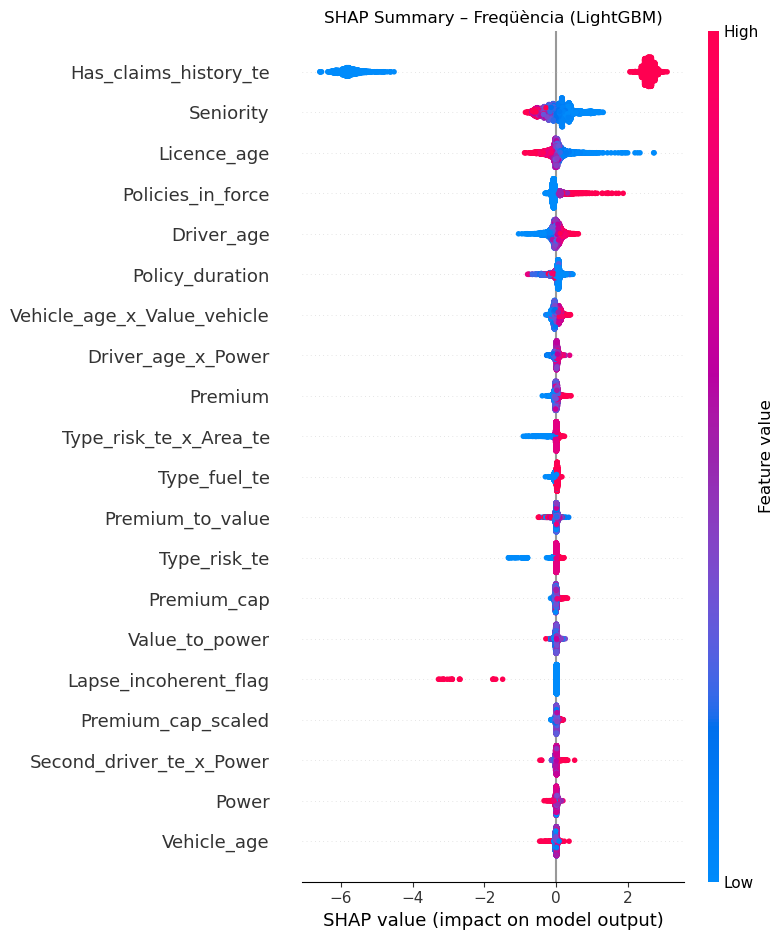

<Figure size 700x500 with 0 Axes>

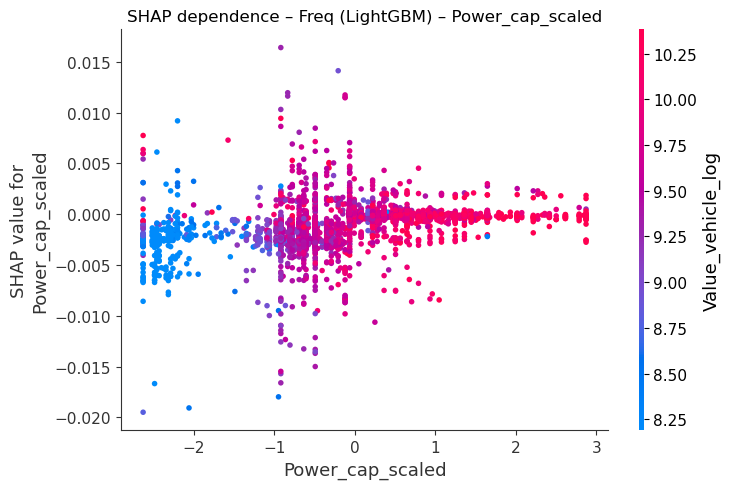

<Figure size 700x500 with 0 Axes>

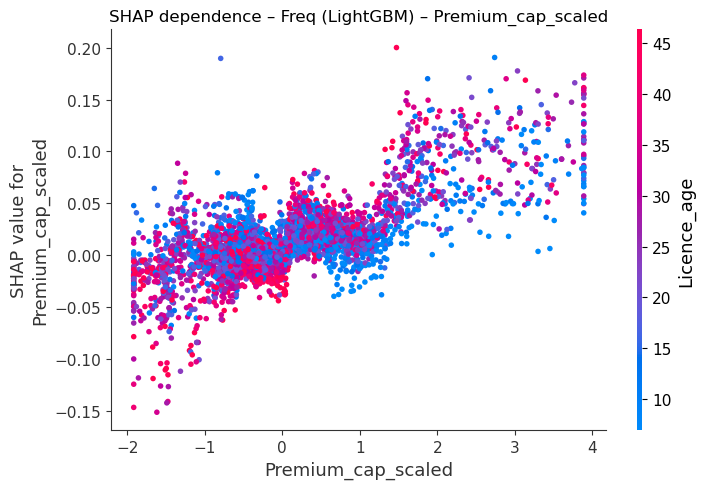

<Figure size 700x500 with 0 Axes>

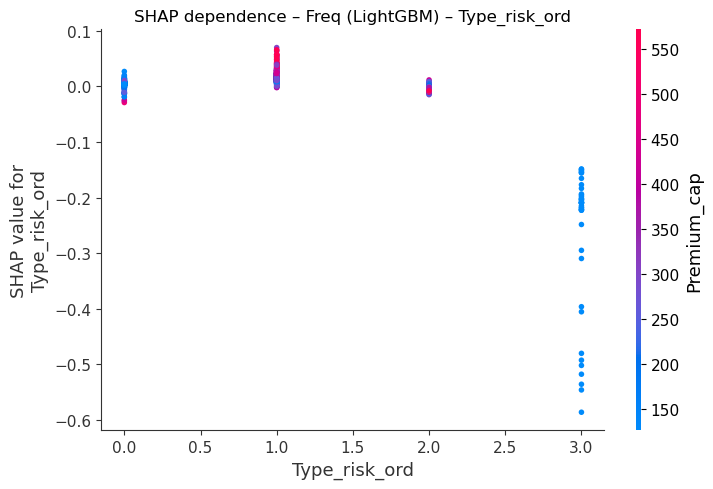

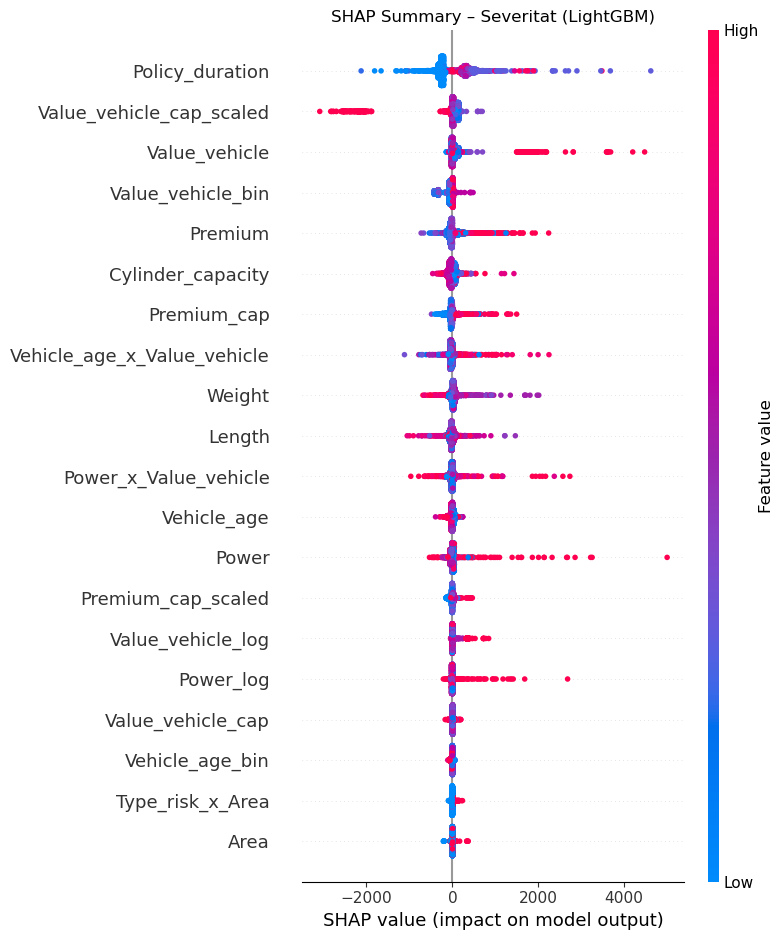

<Figure size 700x500 with 0 Axes>

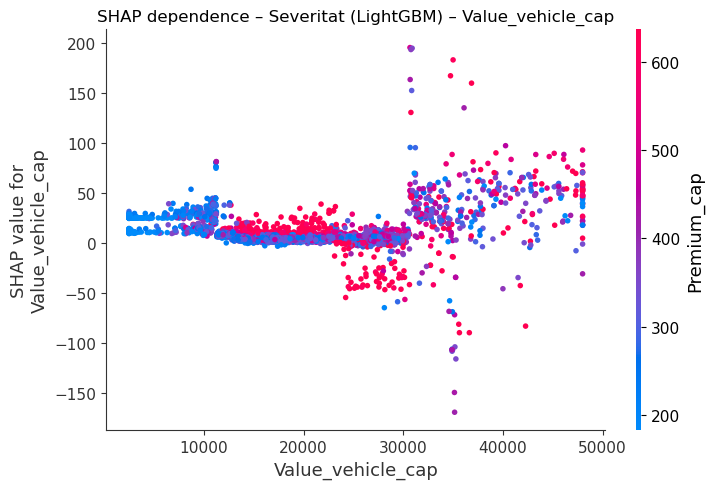

<Figure size 700x500 with 0 Axes>

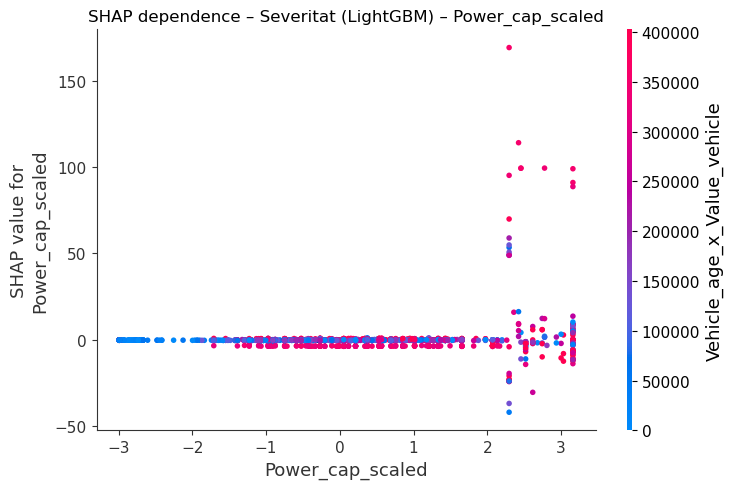

<Figure size 700x500 with 0 Axes>

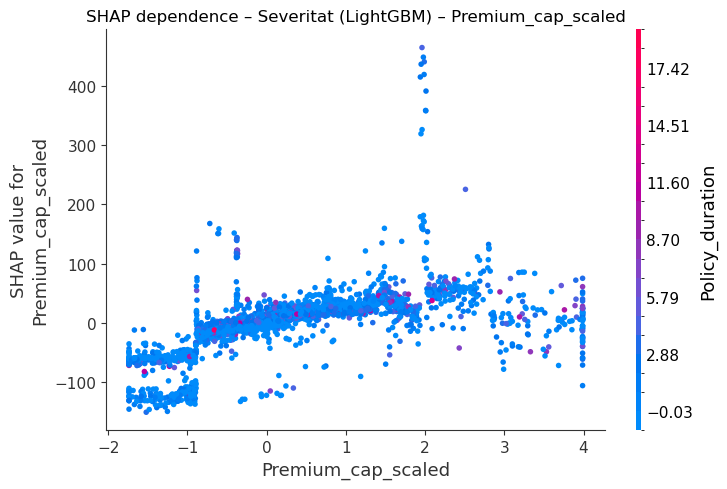


=== TOP 15 variables FREQÜÈNCIA segons mean(|SHAP|) ===
                        feature  mean_abs_shap
32        Has_claims_history_te       3.558731
7                     Seniority       0.302678
1                   Licence_age       0.168677
8             Policies_in_force       0.122956
0                    Driver_age       0.111516
3               Policy_duration       0.090536
34  Vehicle_age_x_Value_vehicle       0.075561
33           Driver_age_x_Power       0.039407
6                       Premium       0.036948
37       Type_risk_te_x_Area_te       0.034928
28                 Type_fuel_te       0.031570
36             Premium_to_value       0.027132
26                 Type_risk_te       0.026859
17                  Premium_cap       0.025969
35               Value_to_power       0.023161

=== TOP 15 variables SEVERITAT segons mean(|SHAP|) ===
                        feature  mean_abs_shap
5               Policy_duration     306.278120
20     Value_vehicle_cap_scaled     145.5

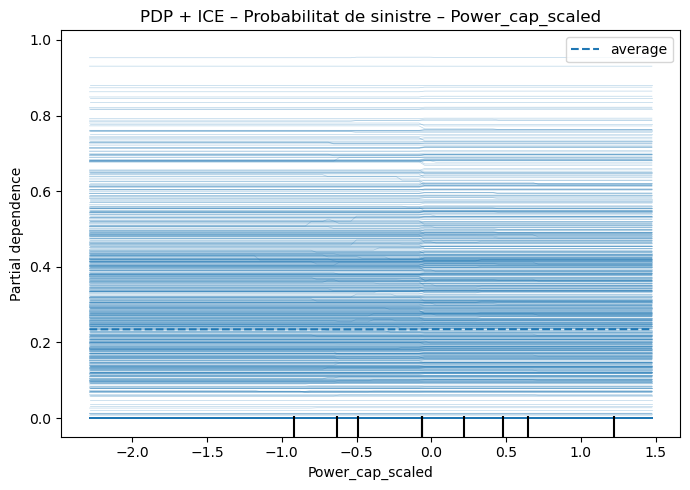

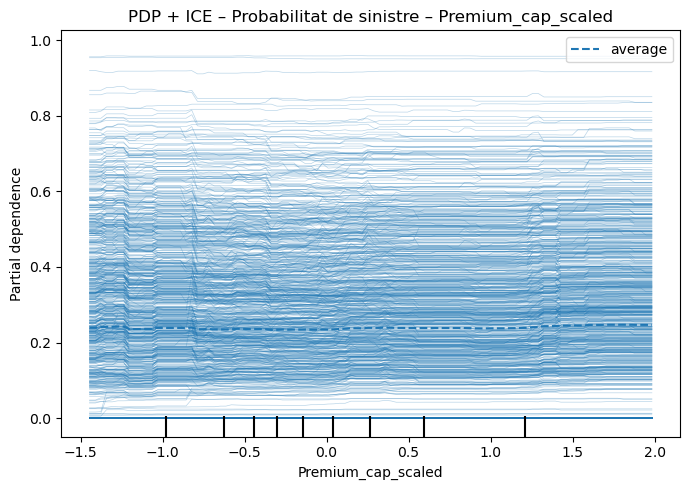


LIME – Explicant la instància de test index 0, y_true = 0

=== Explicació LIME – contribució local de variables ===
Has_claims_history_te <= 0.00: -0.35229282891587643
Lapse_incoherent_flag <= 0.00: 0.22141893568320867
Licence_age > 33.84: -0.08776200297679138
Type_risk_ord <= 2.00: 0.059916726269186926
Driver_age > 53.34: 0.059235987927660105
Policy_duration <= -1.00: 0.0414504673720536
1.00 < Policies_in_force <= 2.00: 0.030834516679185162
Second_driver_te <= 0.18: -0.019550769311898104
Policy_incoherent_flag <= 0.00: 0.015945774949349806
13.52 < Second_driver_te_x_Power <= 17.04: -0.015767239057119797


In [15]:
# =====================================================================
# 4.4.6 INTERPRETABILITAT I EXPLICABILITAT (XAI)
# =====================================================================
# Objectiu:
#   - Aplicar tècniques XAI sobre els models "champion" no lineals:
#       * LightGBM Classifier per a FREQÜÈNCIA
#       * LightGBM Regressor per a SEVERITAT
#   - Generar:
#       * SHAP summary plots (importància global) i dependence plots
#       * PDP + ICE (Partial Dependence / Individual Conditional Expectation)
#       * 1 explicació LIME local per a una pòlissa concreta del test
#
# Notes:
#   - Suposa que ja s’han executat 4.4.3 i 4.4.4 en aquest notebook:
#       * Les funcions prepare_xy_class_freq / prepare_xy_severity /
#         align_train_test ja estan definides i es reutilitzen aquí.
#   - L’objectiu d’aquest script NO és millorar mètriques, sinó
#     entendre com "pensen" els models entrenats.
# =====================================================================

import warnings
warnings.filterwarnings(
    "ignore",
    message="LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray"
)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier, LGBMRegressor

from sklearn.metrics import (
    roc_auc_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.inspection import PartialDependenceDisplay

# ---------------------------------------------------------------------
# 0. IMPORT OPCIONAL DE SHAP I LIME
# ---------------------------------------------------------------------
# Si no estan instal·lats, simplement es desactiven les seccions
# corresponents (no es llança error).
# ---------------------------------------------------------------------

try:
    import shap
    SHAP_AVAILABLE = True
    shap.initjs()
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP no disponible → s'ometran anàlisis SHAP.")

try:
    from lime.lime_tabular import LimeTabularExplainer
    LIME_AVAILABLE = True
except ImportError:
    LIME_AVAILABLE = False
    print("LIME no disponible → s'ometran explicacions LIME.")

# ---------------------------------------------------------------------
# 1. COMPROVACIÓ QUE LES FUNCIONS AUXILIARS EXISTEIXEN
# ---------------------------------------------------------------------

required_funcs = ["prepare_xy_class_freq", "prepare_xy_severity", "align_train_test"]
for fname in required_funcs:
    if fname not in globals():
        raise RuntimeError(
            f"La funció '{fname}' no està definida. "
            "Cal executar abans les cel·les de 4.4.3 / 4.4.4 on es defineixen "
            "les funcions auxiliars de preparació de dades."
        )

# Referències locals a les funcions (per comoditat)
prepare_xy_class_freq = globals()["prepare_xy_class_freq"]
prepare_xy_severity   = globals()["prepare_xy_severity"]
align_train_test      = globals()["align_train_test"]

# ---------------------------------------------------------------------
# 2. PARÀMETRES GENERALS I CARREGA DE DADES
# ---------------------------------------------------------------------

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

BASE_MODEL_PATH = "data/model"

FREQ_GBM_TRAIN_PATH = os.path.join(BASE_MODEL_PATH, "freq_gbm_train.csv")
FREQ_GBM_TEST_PATH  = os.path.join(BASE_MODEL_PATH, "freq_gbm_test.csv")
SEV_TRAIN_PATH      = os.path.join(BASE_MODEL_PATH, "sev_train.csv")
SEV_TEST_PATH       = os.path.join(BASE_MODEL_PATH, "sev_test.csv")

freq_gbm_train = pd.read_csv(FREQ_GBM_TRAIN_PATH)
freq_gbm_test  = pd.read_csv(FREQ_GBM_TEST_PATH)
sev_train      = pd.read_csv(SEV_TRAIN_PATH)
sev_test       = pd.read_csv(SEV_TEST_PATH)

# ---------------------------------------------------------------------
# 3. PREPARACIÓ DE X,y PER ALS MODELS CHAMPION
# ---------------------------------------------------------------------

# ---------- 3.1 Freqüència (classificador binari) ----------
X_train_freq_raw, y_train_freq = prepare_xy_class_freq(
    freq_gbm_train,
    target="Has_claims_year"
)
X_test_freq_raw,  y_test_freq  = prepare_xy_class_freq(
    freq_gbm_test,
    target="Has_claims_year"
)

X_train_freq, X_test_freq = align_train_test(X_train_freq_raw, X_test_freq_raw)

print("Shape FREQ (train X,y):", X_train_freq.shape, y_train_freq.shape)

# ---------- 3.2 Severitat (regressió sobre Cost_claims_year > 0) ----------
X_train_sev_raw, y_train_sev = prepare_xy_severity(
    sev_train,
    target="Cost_claims_year"
)
X_test_sev_raw,  y_test_sev  = prepare_xy_severity(
    sev_test,
    target="Cost_claims_year"
)

X_train_sev, X_test_sev = align_train_test(X_train_sev_raw, X_test_sev_raw)

print("Shape SEV  (train X,y):", X_train_sev.shape, y_train_sev.shape)

# Sanitització extra del target de severitat
y_train_sev = y_train_sev.replace([np.inf, -np.inf], np.nan).fillna(y_train_sev.median())
y_test_sev  = y_test_sev.replace([np.inf, -np.inf], np.nan).fillna(y_test_sev.median())

# Clip (si hi ha algun valor ≤ 0) només si cal (per estabilitat opcional)
if (y_train_sev <= 0).any():
    y_train_sev = y_train_sev.clip(lower=1e-6)
if (y_test_sev <= 0).any():
    y_test_sev = y_test_sev.clip(lower=1e-6)

# ---------------------------------------------------------------------
# 4. ENTRENAMENT DELS MODELS "CHAMPION" (LIGHTGBM)
# ---------------------------------------------------------------------

# 4.1 LightGBM Classifier – FREQÜÈNCIA
lgbm_freq = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.02,
    max_depth=-1,
    num_leaves=63,
    subsample=1.0,
    colsample_bytree=0.8,
    objective="binary",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

lgbm_freq.fit(X_train_freq, y_train_freq)

y_proba_test = lgbm_freq.predict_proba(X_test_freq)[:, 1]
auc_test = roc_auc_score(y_test_freq, y_proba_test)
print(f"AUC LightGBM FREQ (test 2018): {auc_test:.4f}")

# 4.2 LightGBM Regressor – SEVERITAT
lgbm_sev = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.02,
    max_depth=5,
    num_leaves=127,
    subsample=0.7,
    colsample_bytree=0.7,
    objective="regression",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

lgbm_sev.fit(X_train_sev, y_train_sev)

y_pred_sev = lgbm_sev.predict(X_test_sev)
mae_sev = mean_absolute_error(y_test_sev, y_pred_sev)
rmse_sev = np.sqrt(mean_squared_error(y_test_sev, y_pred_sev))
r2_sev = r2_score(y_test_sev, y_pred_sev)
print(f"SEVERITAT LightGBM – MAE={mae_sev:.2f}, RMSE={rmse_sev:.2f}, R²={r2_sev:.3f}")

# =====================================================================
# 5. SHAP – IMPORTÀNCIA GLOBAL I EFECTES MARGINALS
# =====================================================================

if SHAP_AVAILABLE:
    # ---------- 5.1 SHAP per al model de FREQÜÈNCIA ----------
    freq_sample = X_train_freq.sample(
        n=min(5000, len(X_train_freq)),
        random_state=RANDOM_STATE
    )

    explainer_freq = shap.TreeExplainer(lgbm_freq)
    shap_values_freq = explainer_freq.shap_values(freq_sample)

    # Classe 1 (claim)
    if isinstance(shap_values_freq, list) and len(shap_values_freq) == 2:
        shap_values_freq_1 = shap_values_freq[1]
    else:
        shap_values_freq_1 = shap_values_freq

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values_freq_1, freq_sample, show=False)
    plt.title("SHAP Summary – Freqüència (LightGBM)")
    plt.tight_layout()
    plt.show()

    candidate_features_freq = [
        "Driver_age_scaled",
        "Vehicle_age_scaled",
        "Power_cap_scaled",
        "Premium_cap_scaled",
        "Type_risk_ord",
    ]
    freq_features_for_dep = [f for f in candidate_features_freq if f in freq_sample.columns]
    if not freq_features_for_dep:
        freq_features_for_dep = freq_sample.columns[:3].tolist()

    for feat in freq_features_for_dep:
        plt.figure(figsize=(7, 5))
        shap.dependence_plot(
            feat,
            shap_values_freq_1,
            freq_sample,
            show=False
        )
        plt.title(f"SHAP dependence – Freq (LightGBM) – {feat}")
        plt.tight_layout()
        plt.show()

    # ---------- 5.2 SHAP per al model de SEVERITAT ----------
    sev_sample = X_train_sev.sample(
        n=min(5000, len(X_train_sev)),
        random_state=RANDOM_STATE
    )

    explainer_sev = shap.TreeExplainer(lgbm_sev)
    shap_values_sev = explainer_sev.shap_values(sev_sample)

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values_sev, sev_sample, show=False)
    plt.title("SHAP Summary – Severitat (LightGBM)")
    plt.tight_layout()
    plt.show()

    candidate_features_sev = [
        "Value_vehicle_cap",
        "Power_cap_scaled",
        "Premium_cap_scaled",
        "Vehicle_age_scaled",
    ]
    sev_features_for_dep = [f for f in candidate_features_sev if f in sev_sample.columns]
    if not sev_features_for_dep:
        sev_features_for_dep = sev_sample.columns[:3].tolist()

    for feat in sev_features_for_dep:
        plt.figure(figsize=(7, 5))
        shap.dependence_plot(
            feat,
            shap_values_sev,
            sev_sample,
            show=False
        )
        plt.title(f"SHAP dependence – Severitat (LightGBM) – {feat}")
        plt.tight_layout()
        plt.show()

    # ---------- 5.3 Resum numèric SHAP (taules) ----------
    mean_abs_shap_freq = np.mean(np.abs(shap_values_freq_1), axis=0)
    freq_shap_importance = pd.DataFrame({
        "feature": freq_sample.columns,
        "mean_abs_shap": mean_abs_shap_freq,
    }).sort_values("mean_abs_shap", ascending=False)

    print("\n=== TOP 15 variables FREQÜÈNCIA segons mean(|SHAP|) ===")
    print(freq_shap_importance.head(15))

    freq_shap_importance.to_csv(
        os.path.join(BASE_MODEL_PATH, "freq_shap_importance.csv"),
        index=False
    )

    mean_abs_shap_sev = np.mean(np.abs(shap_values_sev), axis=0)
    sev_shap_importance = pd.DataFrame({
        "feature": sev_sample.columns,
        "mean_abs_shap": mean_abs_shap_sev,
    }).sort_values("mean_abs_shap", ascending=False)

    print("\n=== TOP 15 variables SEVERITAT segons mean(|SHAP|) ===")
    print(sev_shap_importance.head(15))

    sev_shap_importance.to_csv(
        os.path.join(BASE_MODEL_PATH, "sev_shap_importance.csv"),
        index=False
    )

# =====================================================================
# 6. PDP I ICE – EFECTES MARGINALS SOBRE LA PROBABILITAT DE SINISTRE
# =====================================================================

X_pdp_sample = X_train_freq.sample(
    n=min(5000, len(X_train_freq)),
    random_state=RANDOM_STATE
)

candidate_pdp_features = [
    "Driver_age_scaled",
    "Vehicle_age_scaled",
    "Power_cap_scaled",
    "Premium_cap_scaled",
]
pdp_features = [f for f in candidate_pdp_features if f in X_pdp_sample.columns]
if not pdp_features:
    pdp_features = X_pdp_sample.columns[:2].tolist()

for feat in pdp_features:
    fig, ax = plt.subplots(figsize=(7, 5))
    PartialDependenceDisplay.from_estimator(
        estimator=lgbm_freq,
        X=X_pdp_sample,
        features=[feat],
        kind="both",                 # PDP + ICE
        response_method="predict_proba",
        target=1,                    # probabilitat de classe 1 (claim)
        ax=ax,
    )
    plt.title(f"PDP + ICE – Probabilitat de sinistre – {feat}")
    plt.tight_layout()
    plt.show()

# =====================================================================
# 7. LIME – EXPLICACIÓ LOCAL D’UNA PÒLISSA CONCRETA
# =====================================================================

if LIME_AVAILABLE:
    def lgbm_predict_proba(X_arr: np.ndarray):
        """
        Wrapper per a LIME:
          - LIME passa un array numpy sense noms de columna.
          - Aquí el convertim a DataFrame amb els mateixos noms que X_train_freq.
        """
        X_df = pd.DataFrame(X_arr, columns=X_train_freq.columns)
        return lgbm_freq.predict_proba(X_df)

    lime_explainer = LimeTabularExplainer(
        training_data=X_train_freq.values,
        feature_names=X_train_freq.columns.tolist(),
        class_names=["no_claim", "claim"],
        mode="classification",
        discretize_continuous=True,
    )

    instance_idx = 0  # pots canviar aquest índex per explicar una altra pòlissa
    x_instance = X_test_freq.iloc[instance_idx].values
    y_true_instance = y_test_freq.iloc[instance_idx]

    print(f"\nLIME – Explicant la instància de test index {instance_idx}, y_true = {y_true_instance}")

    lime_exp = lime_explainer.explain_instance(
        data_row=x_instance,
        predict_fn=lgbm_predict_proba,
        num_features=10,
    )

    print("\n=== Explicació LIME – contribució local de variables ===")
    for feat, contrib in lime_exp.as_list():
        print(f"{feat}: {contrib}")

    # Opcional: visualització en notebook o exportar a HTML
    # lime_exp.show_in_notebook(show_table=True)
    # lime_exp.save_to_file(os.path.join(BASE_MODEL_PATH, "lime_explanation_freq_instance0.html"))

# =====================================================================
# 8. RESUM
# =====================================================================
# - S'han reutilitzat les funcions de preparació de dades de 4.4.3/4.4.4.
# - Els models LightGBM freq/sev s'han entrenat amb els hiperparàmetres
#   òptims trobats al tuning i amb tot el train 2015–2017.
# - SHAP (si disponible) proporciona importància global i efectes
#   marginals, exportats a freq_shap_importance.csv i
#   sev_shap_importance.csv.
# - PDP/ICE mostra la resposta mitjana i individual de la probabilitat
#   de sinistre a canvis en variables clau.
# - LIME (si disponible) dona una explicació local per a una pòlissa
#   concreta del test 2018, útil com a exemple al TFM.
# =====================================================================
